In [1]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from pyspark.sql import SparkSession, HiveContext, functions as f
from PIL import Image
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import happybase
import pandas as pd
from datetime import date, timedelta

In [2]:
#Setting our application name
appname = "YouTube Trends"
 
#Create spark session
spark = SparkSession.builder.appName(appname).enableHiveSupport().getOrCreate()

23/01/09 20:44:48 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
23/01/09 20:44:48 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/01/09 20:44:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
today = date.today() - timedelta(days=1)
today

datetime.date(2023, 1, 8)

# Najbardziej popularne filmy

In [4]:
movies_sql = f"""
                SELECT k.id, s.title, k.counted
                FROM 
                (
                    SELECT id, count(*) as counted
                        from youtubeVideos
                        where datediff(to_date("{today:%Y-%m-%d}"), to_date(partition_dt)) <= 7
                        group by id
                        order by counted desc
                        limit 10
                ) k
                INNER JOIN (
                    SELECT DISTINCT id, title
                    FROM youtubeVideos
                    WHERE datediff(to_date("{today:%Y-%m-%d}"), to_date(partition_dt)) <= 7 
                ) s
                ON k.id = s.id
                WHERE length(title) > 1
                ORDER BY counted DESC
             """
movies_res = spark.sql(movies_sql)
movies_res.write.orc(f"/user/project/visual/{today:%Y%m%d}/popular_movies.orc")
movies_res = movies_res.toPandas()
movies_res["url"] = "https://www.youtube.com/watch?v=" + movies_res["id"]
movies_res = movies_res.drop(columns="id")
def make_clickable(val):
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

movies_res.style.format({'url': make_clickable})

23/01/09 20:45:11 WARN session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


,title,counted,url
0,Quavo - WITHOUT YOU,13844,https://www.youtube.com/watch?v=_uS8QRe2qfE
1,Popcaan - We Caa Done Ft Drake (Official Video),13844,https://www.youtube.com/watch?v=TjJZNdLSexU
2,I Strapped A GoPro To A Fish!,13844,https://www.youtube.com/watch?v=NigrQ9UcJy4
3,YoungBoy Never Broke Again - Black ( Official Music Video ),13844,https://www.youtube.com/watch?v=WFBVYRy962k
4,I'M PRINCESS PROTECTION PROGRAM,13844,https://www.youtube.com/watch?v=kEnh_5z4I7w
5,"FLETCHER, Kelsea Ballerini - Better Version",13579,https://www.youtube.com/watch?v=uhPPttviktc
6,Ram Revolution EV Truck: You Won't Believe the Crazy Features In This Ford Lightning Competitor!,13430,https://www.youtube.com/watch?v=bNxUZx6GNaU
7,This Minecraft Three Player Prison is IMPOSSIBLE...,13092,https://www.youtube.com/watch?v=ilksTfRzugQ
8,City of Flowers // Lotus Official Map Trailer - VALORANT,12698,https://www.youtube.com/watch?v=QbQk_7sFec4
9,[GUIDE] RACE V4 PUZZLE FINAL STEP Blox Fruits,8249,https://www.youtube.com/watch?v=oWnkpb-dSms


# TAGI

In [5]:
tags_sql = f"""select id, split(lcase(tags), ';') as tag 
              from youtubeVideos
              where datediff(to_date("{today:%Y-%m-%d}"), partition_dt) <= 7"""
tags_res = spark.sql(tags_sql)
tags_res = tags_res.withColumn("tags_new", f.expr("array_join(array_distinct(tag),' ')"))
tags_res.write.orc(f"/user/project/visual/{today:%Y%m%d}/tags_wc.orc")
tags = tags_res.select('tags_new').rdd.flatMap(lambda x: x).collect()
tags = " ".join(filter(lambda x: x is not None, tags))

In [6]:
char_mask = np.array(Image.open("/home/vagrant/big-data-main/images/yt_logo.png"))    
image_colors = ImageColorGenerator(char_mask)

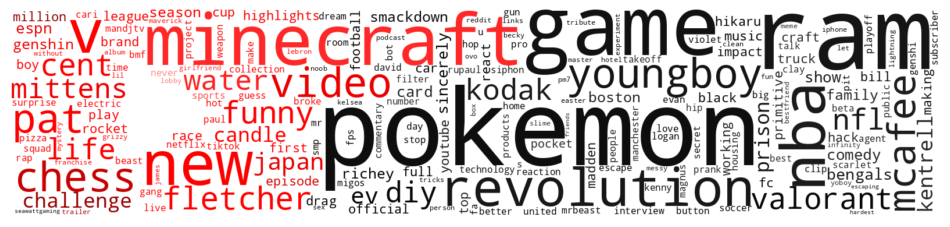

In [7]:
wc = WordCloud(width=700, height=400, stopwords=STOPWORDS, mask=char_mask, background_color="white", collocations=False)
wc.generate_from_text(tags)
plt.figure(figsize=(12, 10))
plt.axis("off")
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.savefig("plots/tags_world_cloud")
plt.show()

In [8]:
tags_sql = f""" SELECT lcase(k.tag) as tag, count(distinct k.id) as counted, max(partition_dt) as last_day
    FROM (
        select id, partition_dt, explode(tags) as tag
        from ytVideosConverted
        where datediff(to_date("{today:%Y-%m-%d}"), to_date(partition_dt)) <= 7
    ) k 
    GROUP BY lcase(k.tag)
    """
tags_counted = spark.sql(tags_sql)
most_used_tags = tags_counted.select("tag", "counted").orderBy(f.col("counted").desc()).limit(10)
tags_res.write.orc(f"/user/project/visual/{today:%Y%m%d}/tags_popular.orc")
most_used_tags_df = most_used_tags.toPandas() 
most_used_tags_df

,tag,counted
0,funny,9
1,comedy,9
2,challenge,6
3,nba,5
4,sports,5
5,basketball,4
6,nfl,4
7,rap,4
8,american football,3
9,fun,3


/home/vagrant/.local/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


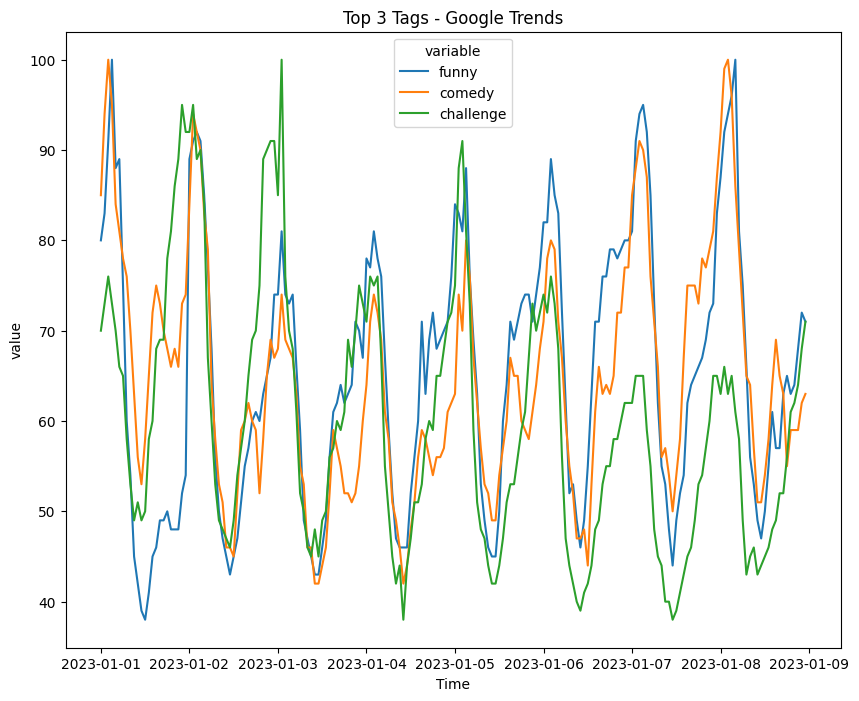

In [9]:
most_used_tags = tags_counted.select("tag", "counted", "last_day").orderBy(f.col("counted").desc()).limit(3)
most_tags = most_used_tags.toPandas()
most_tags["keys"] = most_tags["last_day"].astype(str) + "_" + most_tags["tag"]


connection = happybase.Connection('localhost')
table = connection.table('Tags')
tags = []
for key_val, data in table.rows(rows=[key for key in most_tags["keys"]], columns=[b'meta:tag', b'value']):
    dates = []
    values = []
    for key, value in data.items():
        key_decoded = key.decode("utf-8")
        val_decoded = value.decode("utf-8")
        if key_decoded == "meta:tag":
            tag = value.decode("utf-8")
        else:
            dates.append(key_decoded.split(":")[1])
            values.append(int(val_decoded))
    tags.append(pd.Series(data=values, index=dates, name=tag))
tags_df = pd.concat(tags, axis=1)
tags_df.index = pd.to_datetime(tags_df.index, format="%Y-%m-%d_%H")
tags_df = tags_df.reset_index(names="Time")
tags_df = tags_df.melt(id_vars=["Time"])
tags_spark = spark.createDataFrame(tags_df)
tags_res.write.orc(f"/user/project/visual/{today:%Y%m%d}/tags_trends.orc")
plt.figure(figsize=(10, 8))
plt.title("Top 3 Tags - Google Trends")
sns.lineplot(tags_df, x="Time", y="value", hue="variable")
plt.savefig("plots/tags_trends")
plt.show()

23/01/09 20:48:18 WARN hdfs.DFSClient: Caught exception             (0 + 2) / 2]
java.lang.InterruptedException
	at java.lang.Object.wait(Native Method)
	at java.lang.Thread.join(Thread.java:1252)
	at java.lang.Thread.join(Thread.java:1326)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.closeResponder(DFSOutputStream.java:716)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.endBlock(DFSOutputStream.java:476)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.run(DFSOutputStream.java:652)
23/01/09 20:48:18 WARN hdfs.DFSClient: Caught exception 
java.lang.InterruptedException
	at java.lang.Object.wait(Native Method)
	at java.lang.Thread.join(Thread.java:1252)
	at java.lang.Thread.join(Thread.java:1326)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.closeResponder(DFSOutputStream.java:716)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.closeInternal(DFSOutputStream.java:684)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.run(DFSOutputStream

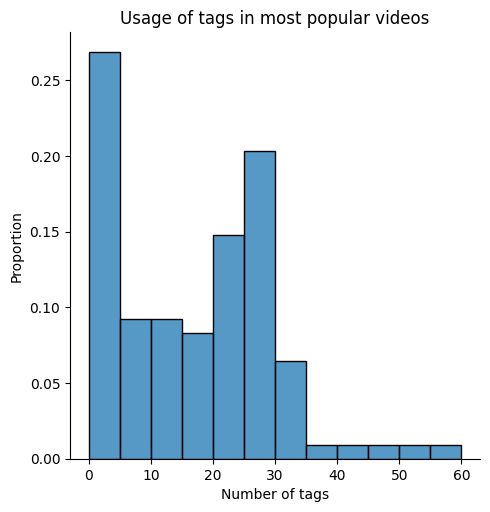

In [10]:
tags_in_popular_sql = f"""
        select distinct id, size(tags) as number_of_tags 
        from ytVideosConverted
        where datediff(to_date("{today:%Y-%m-%d}"), to_date(partition_dt)) <= 7
"""
tags_in_popular = spark.sql(tags_in_popular_sql)
tags_in_popular.write.orc(f"/user/project/visual/{today:%Y%m%d}/tags_usage.orc")
tags_in_popular = tags_in_popular.replace(-1, 0)
tags_in_popular = tags_in_popular.toPandas()
sns.displot(tags_in_popular, x="number_of_tags", stat="proportion", binwidth=5)
plt.title("Usage of tags in most popular videos")
plt.xlabel("Number of tags")
plt.savefig("plots/usage_tags")
plt.show()

# Kategorie

In [11]:
main_table_path = "/user/project/master/youtubeVideos"
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
list_status = fs.listStatus(spark._jvm.org.apache.hadoop.fs.Path(main_table_path))
partitions = [file.getPath().getName() for file in list_status]

for i, partition in enumerate(partitions):
    if i > 0:
        df_temp = spark.read.orc(f"{main_table_path}/{partition}").select("id", "category_id", "partition_dt")
        df = df.union(df_temp)
    else:
        df = spark.read.orc(f"{main_table_path}/{partition}").select("id", "category_id", "partition_dt")
df.createTempView("moviesCategories")

23/01/09 20:48:33 WARN hdfs.DFSClient: Caught exception           (5 + 2) / 200]
java.lang.InterruptedException
	at java.lang.Object.wait(Native Method)
	at java.lang.Thread.join(Thread.java:1252)
	at java.lang.Thread.join(Thread.java:1326)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.closeResponder(DFSOutputStream.java:716)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.endBlock(DFSOutputStream.java:476)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.run(DFSOutputStream.java:652)
23/01/09 20:48:33 WARN hdfs.DFSClient: Caught exception          (10 + 2) / 200]
java.lang.InterruptedException
	at java.lang.Object.wait(Native Method)
	at java.lang.Thread.join(Thread.java:1252)
	at java.lang.Thread.join(Thread.java:1326)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.closeResponder(DFSOutputStream.java:716)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.closeInternal(DFSOutputStream.java:684)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStre

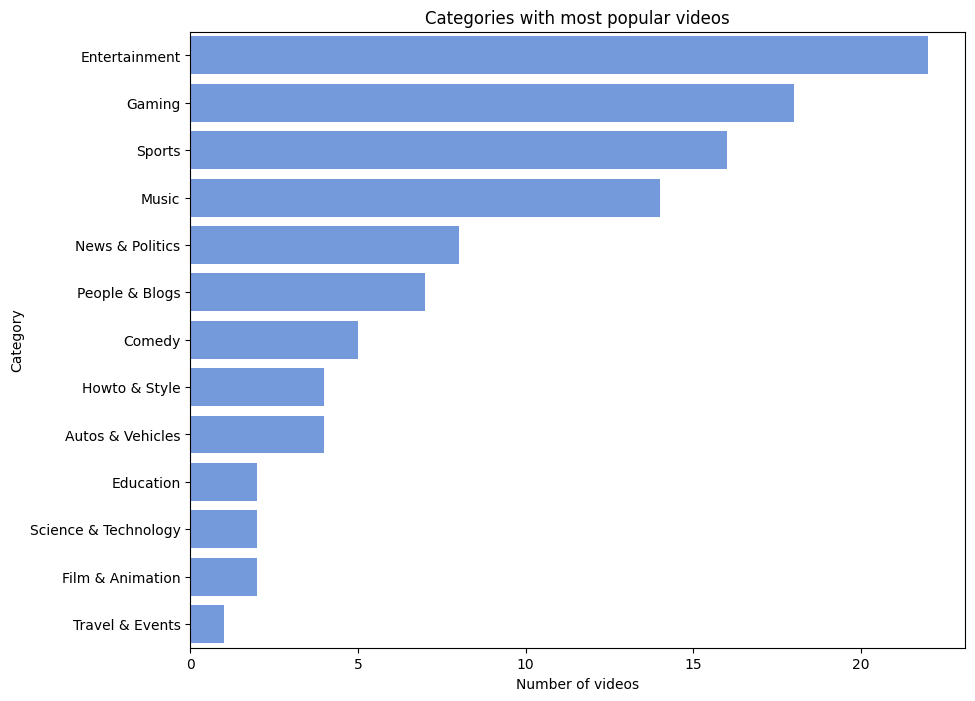

In [12]:
categories_sql = f"""
    SELECT c.title as Category, count(distinct v.id) as `Number of videos` 
    FROM moviesCategories v
    INNER JOIN youtubeVideoCategories c
    ON v.category_id = c.id AND to_date(partition_dt) = to_date(c.fetch_time)
    WHERE v.category_id is not NULL AND datediff(to_date("{today:%Y-%m-%d}"), to_date(partition_dt)) <= 7
    GROUP BY c.title
    """
categories = spark.sql(categories_sql)
categories.write.orc(f"/user/project/visual/{today:%Y%m%d}/categories.orc")
categories = categories.toPandas()
plt.figure(figsize=(10, 8))
sns.barplot(categories.sort_values("Number of videos", ascending=False), y="Category", x="Number of videos", orient="h", color="CornflowerBlue")
plt.title("Categories with most popular videos")
plt.savefig("plots/category")
plt.show()

# Like, Komentarze, Wyświetlenia

23/01/09 20:48:47 WARN hdfs.DFSClient: Caught exception           (0 + 2) / 200]
java.lang.InterruptedException
	at java.lang.Object.wait(Native Method)
	at java.lang.Thread.join(Thread.java:1252)
	at java.lang.Thread.join(Thread.java:1326)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.closeResponder(DFSOutputStream.java:716)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.endBlock(DFSOutputStream.java:476)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.run(DFSOutputStream.java:652)
/home/vagrant/.local/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


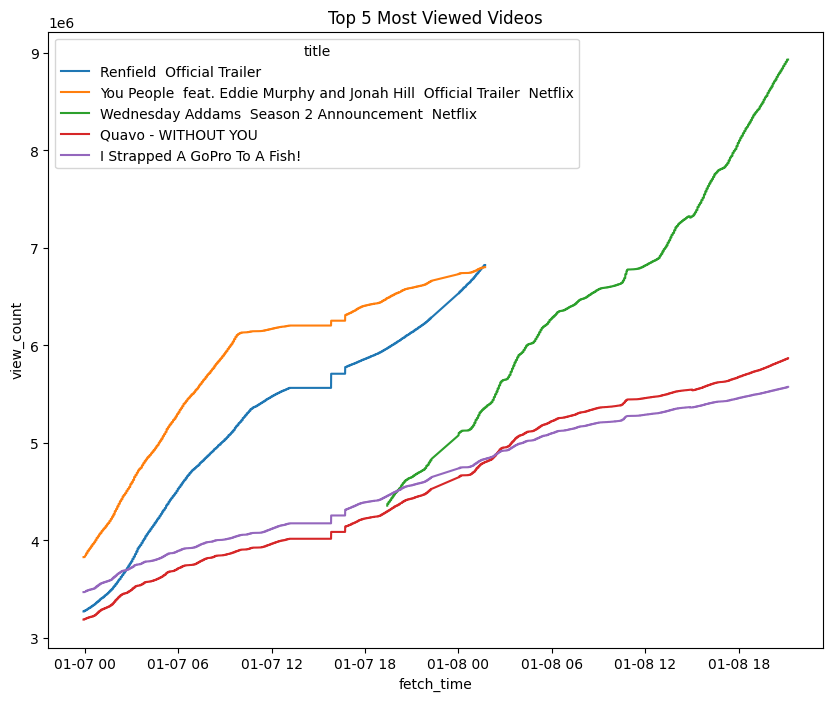

In [13]:
view_sql = f"""
                SELECT COALESCE(k.title, v.id) as title, v.fetch_time, v.view_count
                    FROM ytVideosConverted v
                    LEFT JOIN 
                    (
                        SELECT DISTINCT id, title
                        FROM ytVideosConverted
                        WHERE length(title) > 0
                    )  k
                    ON k.id = v.id
                   WHERE datediff(to_date("{today:%Y-%m-%d}"), to_date(partition_dt)) <= 7 AND v.id in (
                            SELECT id FROM ytVideosConverted
                            group by id
                            order by max(view_count) desc
                            limit 5
                    )
                   
             """


view_res = spark.sql(view_sql)
view_res.write.orc(f"/user/project/visual/{today:%Y%m%d}/viewes.orc")
view_df = view_res.toPandas()
plt.figure(figsize=(10, 8))
plt.title("Top 5 Most Viewed Videos")
sns.lineplot(view_df, x="fetch_time", y="view_count", hue="title")
plt.savefig("plots/view_videos")
plt.show()

/home/vagrant/.local/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


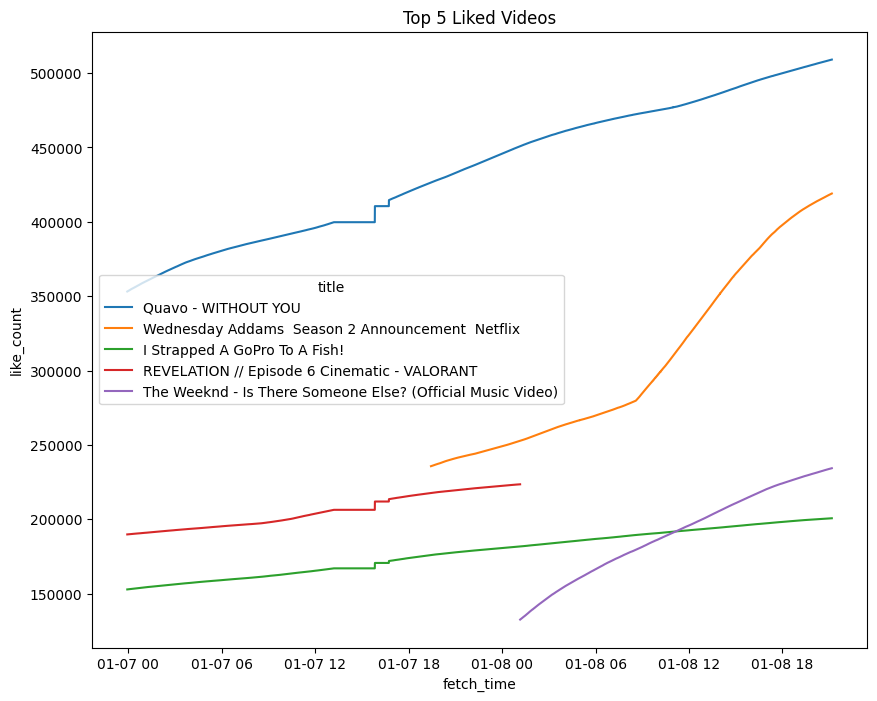

In [14]:
likes_sql = f"""
                SELECT v.id, k.title, fetch_time, like_count
                    FROM ytVideosConverted v
                    INNER JOIN 
                    (
                        SELECT DISTINCT id, title
                        FROM ytVideosConverted
                        WHERE length(title) > 0
                    )  k
                    ON k.id = v.id
                   WHERE datediff(to_date("{today:%Y-%m-%d}"), to_date(partition_dt)) <= 7 AND v.id in (
                            SELECT id FROM ytVideosConverted
                            group by id
                            order by max(like_count) desc
                            limit 5
                    )
                   
             """

likes_res = spark.sql(likes_sql)
likes_res.write.orc(f"/user/project/visual/{today:%Y%m%d}/likes.orc")
likes_df = likes_res.toPandas()
plt.figure(figsize=(10, 8))
plt.title("Top 5 Liked Videos")
sns.lineplot(likes_df, x="fetch_time", y="like_count", hue="title")
plt.savefig("plots/liked_videos")
plt.show()

/home/vagrant/.local/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


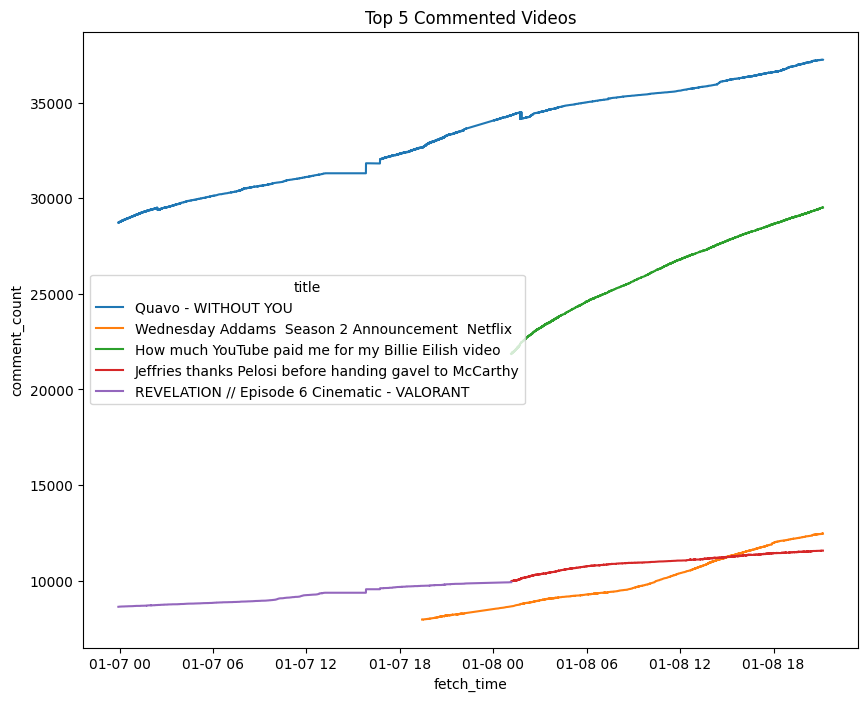

In [15]:
comment_sql = f"""
                SELECT v.id, k.title, v.fetch_time, v.comment_count
                    FROM ytVideosConverted v
                    INNER JOIN 
                    (
                        SELECT DISTINCT id, title
                        FROM ytVideosConverted
                        WHERE length(title) > 0
                    )  k
                    ON k.id = v.id
                   WHERE datediff(to_date("{today:%Y-%m-%d}"), to_date(partition_dt)) <= 7 AND v.id in (
                            SELECT id FROM ytVideosConverted
                            group by id
                            order by max(comment_count) desc
                            limit 5
                    )
                   
             """


comment_res = spark.sql(comment_sql)
comment_res.write.orc(f"/user/project/visual/{today:%Y%m%d}/comments.orc")
comment_df = comment_res.toPandas()
plt.figure(figsize=(10, 8))
plt.title("Top 5 Commented Videos")
sns.lineplot(comment_df, x="fetch_time", y="comment_count", hue="title")
plt.savefig("plots/comment_videos")
plt.show()